# 1. Predict Loan Approval (DecisionTreeClassifier)

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pk
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [123]:
loandata = pd.DataFrame(pd.read_csv('cleaned_loan_data.csv'))
loandata.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,assets,loan_status
0,2,1,0,9600000,29900000,12,778,50700000,1
1,0,0,1,4100000,12200000,8,417,17000000,0
2,3,1,0,9100000,29700000,20,506,57700000,0
3,3,1,0,8200000,30700000,8,467,52700000,0
4,5,0,1,9800000,24200000,20,382,55000000,0


# Train the Model

In [124]:
x = loandata.iloc[:, :8]
y = loandata.iloc[:, 8]

In [125]:
y.value_counts()

loan_status
1    2656
0    1613
Name: count, dtype: int64

In [126]:
# split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=100)

In [ ]:
# Train Logistic Regression model
model = DecisionTreeClassifier(max_depth=4)
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [128]:
# evaluate the model
y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy, "\n")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9707259953161592 

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       317
           1       0.96      0.99      0.98       537

    accuracy                           0.97       854
   macro avg       0.97      0.96      0.97       854
weighted avg       0.97      0.97      0.97       854



# Hyperparameter tuning

In [129]:
param_grid = {
    "max_depth": [range(1, 10), None],
    "criterion": ["gini", "entropy"]
}

hp_dt_model = DecisionTreeClassifier(random_state=42)

# applying crossvalidation with 10 splits
cvals = KFold(n_splits=12)

# use grid search to find the best hyperparameters
grid_search = GridSearchCV(hp_dt_model, param_grid, cv=cvals)
grid_search.fit(x_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None}
Best Accuracy Score: 0.9839026851165471


# Evaluate the model

In [ ]:
#craete optimized model
model_x = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)
model_x.fit(x_train, y_train)

# evaluate the optimized model
y_pred = model_x.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy, "\n")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9871194379391101 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       317
           1       0.99      0.99      0.99       537

    accuracy                           0.99       854
   macro avg       0.99      0.99      0.99       854
weighted avg       0.99      0.99      0.99       854



In [131]:
# do a test prediction
test_data = [[1, 0, 0, 6000000, 40000000, 12, 721, 40000000]]
prediction = model_x.predict(test_data)
print(prediction)

[1]


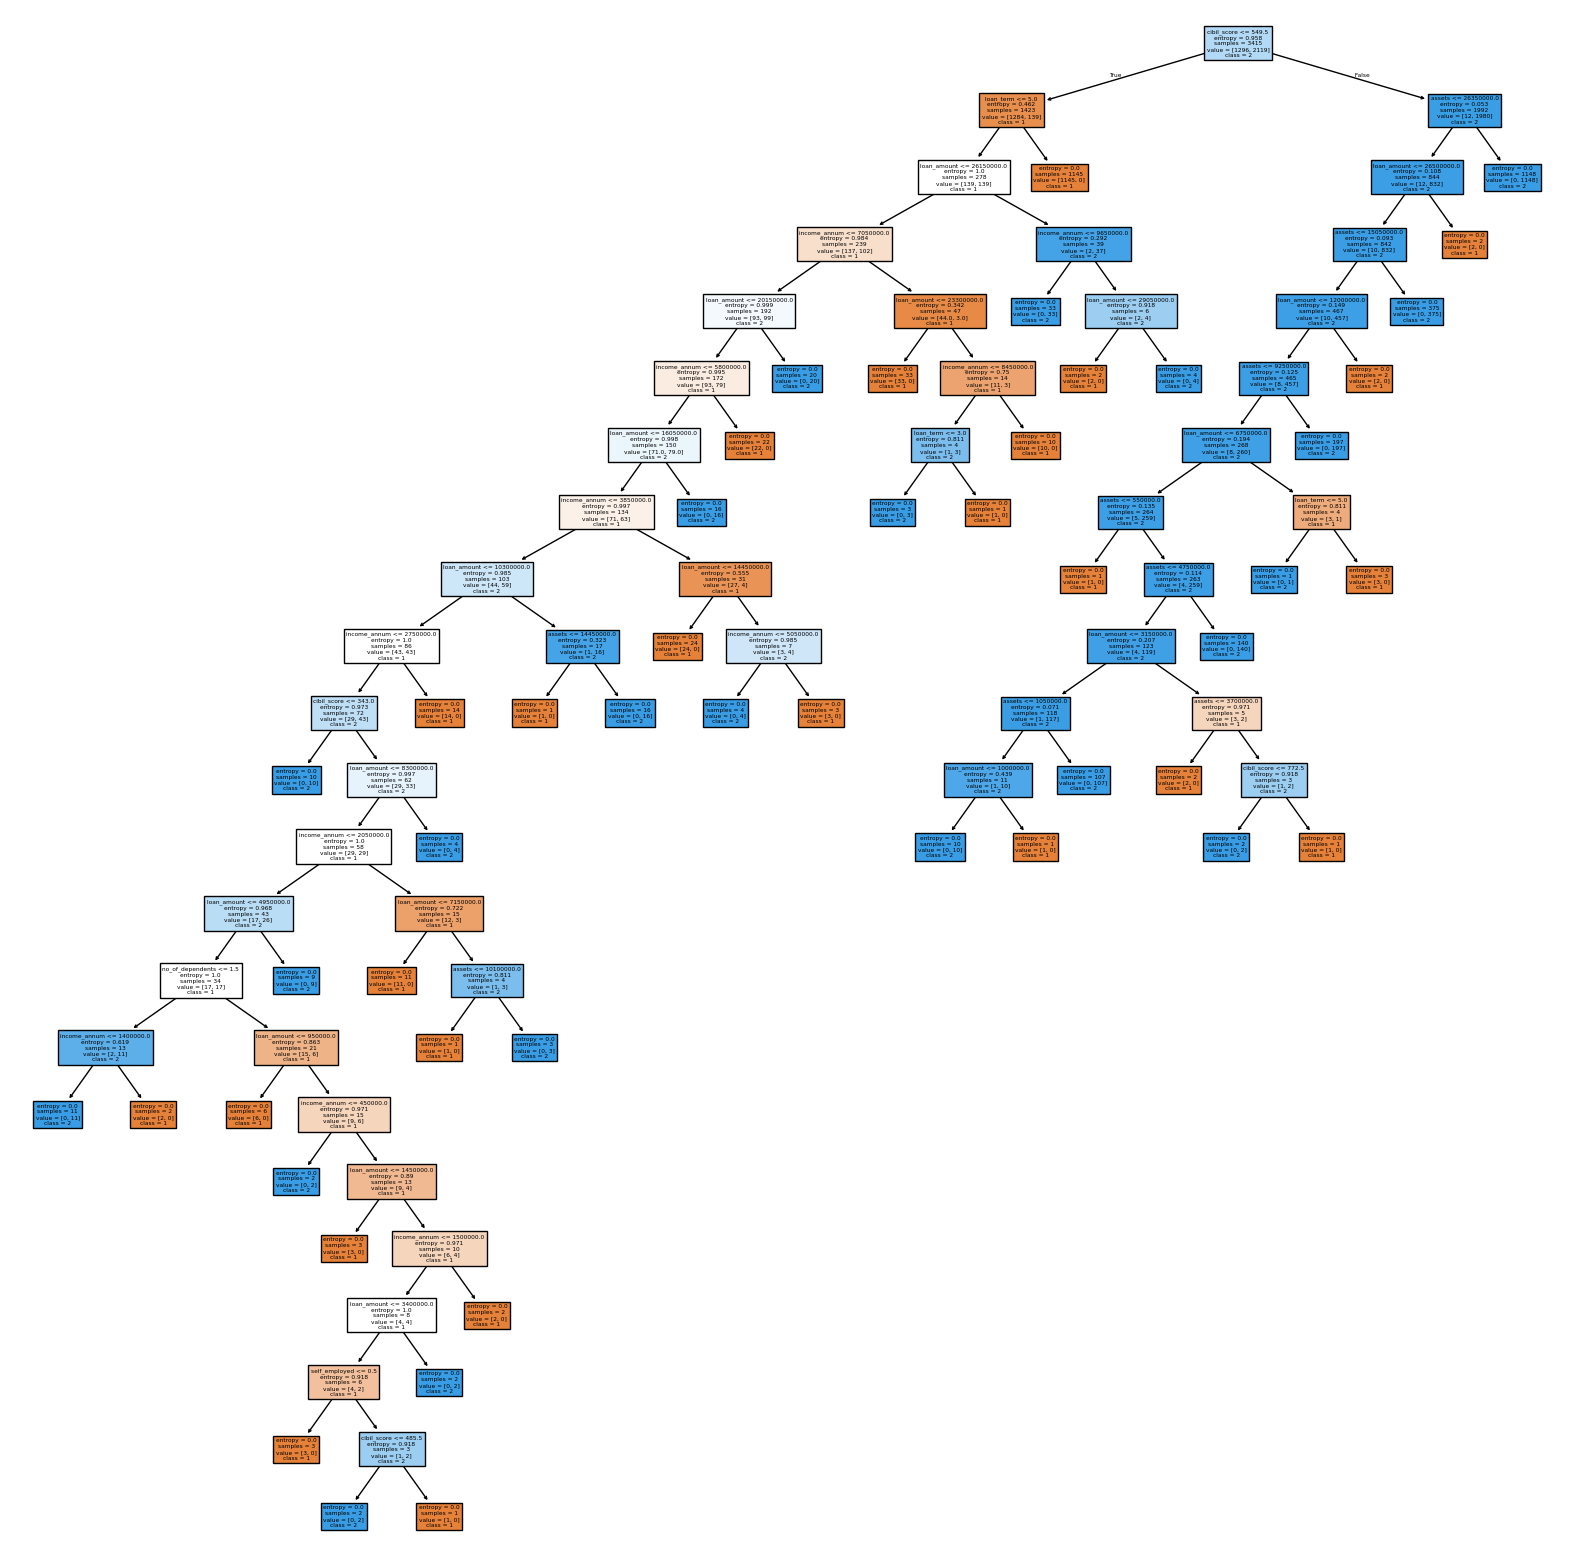

In [132]:
# draw the decision tree
plt.figure(figsize=(20,20))
plot_tree(model_x, feature_names=(loandata.columns),class_names=['1','2'], filled= True)
plt.show()

# PCA Scaled & Re create model

In [133]:
# scale the data before scaling with PCA
# cuz PCA is sensitive to the scale of the data 
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [134]:
from sklearn.decomposition import PCA

#apply PCA with 0.95 variance
pca = PCA(0.95)
x_pca = pca.fit_transform(x_scaled)

In [135]:
# re-split the data into training and testing sets
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y, train_size=0.8, test_size=0.2, random_state=100)

In [136]:
# Train Logistic Regression model
model_pca = DecisionTreeClassifier(max_depth=4)
model_pca.fit(x_train_pca, y_train_pca)

DecisionTreeClassifier(max_depth=4)

In [137]:
y_pred_pca = model_pca.predict(x_test_pca)

accuracy = accuracy_score(y_test_pca, y_pred_pca)
print("Model Accuracy:", accuracy, "\n")
print(classification_report(y_test_pca, y_pred_pca))

Model Accuracy: 0.8571428571428571 

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       317
           1       0.90      0.87      0.88       537

    accuracy                           0.86       854
   macro avg       0.85      0.85      0.85       854
weighted avg       0.86      0.86      0.86       854



<span style="color: yellow; font-weight: bold;">⚠️ Since PCA model accuracy is low, we will continue using Optimized model (model_x)</span> 

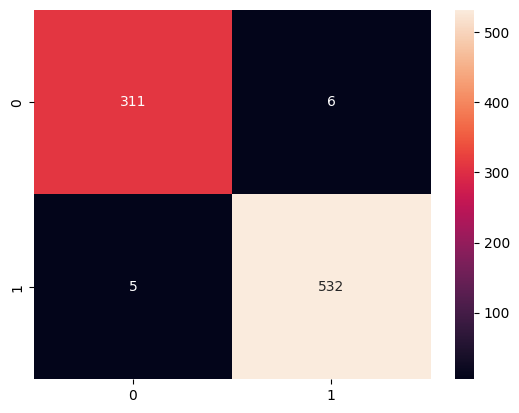

In [138]:
# draw the confusion matrix heatmap
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.show()

In [139]:

y_pred_probs = model_x.predict_proba(x_test)[:, 1] # keep probabilities for the positive outcome only

In [140]:
fpr, tpr, _ = roc_curve(y_test, y_pred_probs) #we are goint to produce the ROC curve

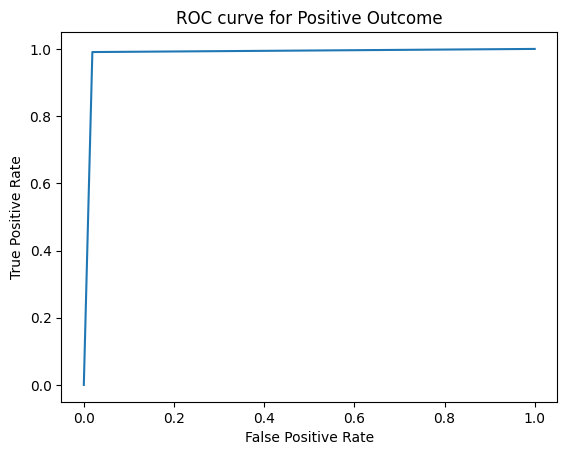

In [141]:
plt.plot(fpr, tpr)
plt.title('ROC curve for Positive Outcome')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Build the Model

In [ ]:
os.makedirs("backend", exist_ok=True)

# save the optimized model inside backend folder
pk.dump(model_x, open("backend/model_1.pkl", "wb"))